In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy
import pandas
import seaborn
import tensorflow
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Reshape, GlobalAveragePooling1D, Conv1D, MaxPooling1D
from keras import utils

In [2]:
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

# Not used right now
def feature_normalize(dataset):

    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

def plot_kelas(kelas, data):

    fig, (ax0) = plt.subplots(nrows=1,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['id'], data['VMPressure'], 'VMPressure')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(kelas)
    plt.subplots_adjust(top=0.90)
    plt.show()

def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 1
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['vm_pressure'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        # Check if the mode is a scalar and handle it accordingly
        mode_result = stats.mode(df[label_name][i: i + time_steps])
        # Fix: Check if mode_result.mode is a scalar or an array
        label = mode_result.mode if np.isscalar(mode_result.mode) else mode_result.mode[0]
        segments.append([xs])
        labels.append(label)



        # label = stats.mode(df[label_name][i: i + time_steps]).mode[0]
        # segments.append([xs])
        # labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [3]:
# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)


LABELS = ['VM', 'Tanpa VM']
TIME_PERIODS = 100
STEP_DISTANCE = 1
BATCH_SIZE = 400
EPOCHS = 50
LABEL_CLASS_ENCODED = 'class_encoded'

keras version  3.7.0


In [4]:
df = pd.read_csv('dataset.csv', header=None, names=['id', 'class', 'vm_pressure'])

df.head()

,id,class,vm_pressure
0,10,1,125
1,10,1,130
2,10,1,155
3,10,1,143
4,10,1,108


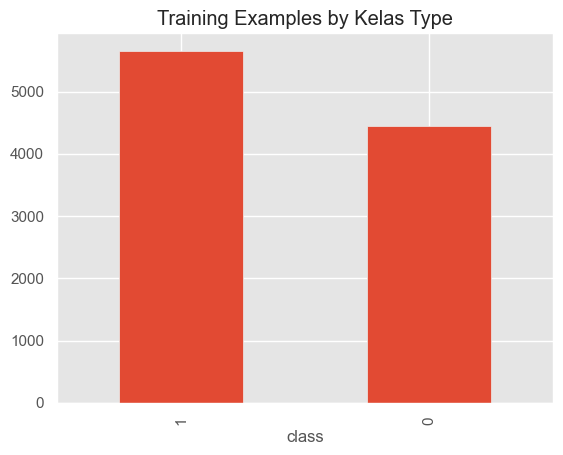

In [5]:
df['class'].value_counts().plot(kind='bar', title='Training Examples by Kelas Type')
plt.show()

In [6]:
encoder = preprocessing.LabelEncoder()
df[LABEL_CLASS_ENCODED] = encoder.fit_transform(df['class'].values.ravel())

df_test = df[df['id'] > 20]
df_train = df[df['id'] <= 20]

df_train['vm_pressure'] = feature_normalize(df['vm_pressure'])
x_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE, LABEL_CLASS_ENCODED)

C:\Users\atmatech\AppData\Local\Temp\ipykernel_24760\983505379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['vm_pressure'] = feature_normalize(df['vm_pressure'])


In [7]:
print('x_train shape: ', x_train.shape)
print('y_train shape: ', y_train.shape)
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = encoder.classes_.size
print(list(encoder.classes_))

x_train shape:  (7878, 100, 1)
y_train shape:  (7878,)
[np.int64(0), np.int64(1)]


In [8]:
input_shape = (num_time_periods*num_sensors)

x_train = x_train.reshape(x_train.shape[0], input_shape)

print('x_train shape:', x_train.shape)

print('input_shape:', input_shape)

x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

y_train = utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

x_train shape: (7878, 100)
input_shape: 100
New y_train shape:  (7878, 2)


In [10]:
model = Sequential()
model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
model.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
model.add(MaxPooling1D(2))
model.add(Conv1D(160, 10, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='sigmoid'))

# model.summary()

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7475 - loss: 0.5030 - val_accuracy: 0.8934 - val_loss: 0.2548
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.8687 - loss: 0.3266 - val_accuracy: 0.8915 - val_loss: 0.2680
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.8805 - loss: 0.2920 - val_accuracy: 0.8972 - val_loss: 0.2243
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8916 - loss: 0.2635 - val_accuracy: 0.9029 - val_loss: 0.1970
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.9038 - loss: 0.2283 - val_accuracy: 0.9239 - val_loss: 0.1596
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9167 - loss: 0.2155 - val_accuracy: 0.8877 - val_loss: 0.2179
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9307 - loss: 0.1850 - val_accuracy: 0.9270 - val_loss: 0.1508
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9440 - loss: 0.1575 - val_accuracy: 0.9270 - 

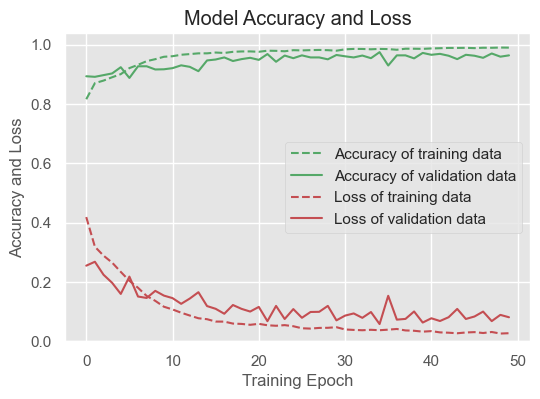

In [12]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [13]:
df_test['vm_pressure'] = feature_normalize(df_test['vm_pressure'])
df_test = df_test.round({'vm_pressure': 6})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL_CLASS_ENCODED)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = utils.to_categorical(y_test, num_classes)

score = model.evaluate(x_test, y_test, verbose=0)

print('Accuracy on test data: %0.2f' % score[1])
print('Loss on test data: %0.2f' % score[0])

C:\Users\atmatech\AppData\Local\Temp\ipykernel_24760\1404401286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['vm_pressure'] = feature_normalize(df_test['vm_pressure'])


Accuracy on test data: 0.92
Loss on test data: 0.22


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


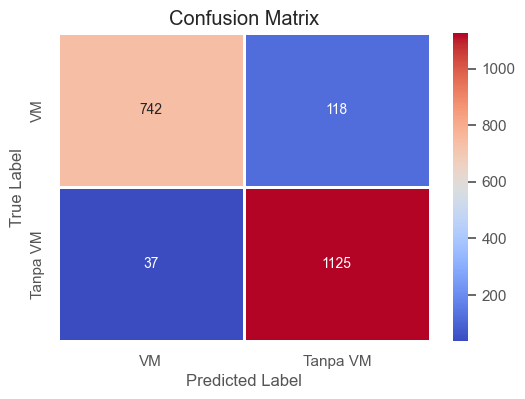

In [14]:
y_pred_test = model.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(6, 4))
sns.heatmap(matrix,
            cmap="coolwarm",
            linecolor='white',
            linewidths=1,
            xticklabels=LABELS,
            yticklabels=LABELS,
            annot=True,
            fmt="d")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

#=========================================================================================================#
# print("\n--- Classification report for test data ---\n")

# print(classification_report(max_y_test, max_y_pred_test))



In [15]:
model.save('model.h5')

In [109]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpxuydsvc3\assets


INFO:tensorflow:Assets written to: C:\Users\atmatech\AppData\Local\Temp\tmpxuydsvc3\assets


Saved artifact at 'C:\Users\atmatech\AppData\Local\Temp\tmpxuydsvc3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100), dtype=tf.float32, name='keras_tensor_203')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2031425424848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031425427152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031425427536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031425428112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031425426192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2031425429264: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [30]:
y_pred_test = model.predict(numpy.array([x_test[1]]))

print(y_pred_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[2.600384e-04 9.999747e-01]]


In [25]:
print(x_test[:1])

[[-1.3285   -1.12486  -1.101587 -0.8514   -0.327754  0.23662   0.533352
   0.667173  0.620627  0.515897  0.486806  0.725356  1.185001  1.417732
   1.505006  1.557371  1.580644  1.609736  1.62719   1.603917  1.598099
   1.615554  1.592281  1.580644  1.563189  1.534098  1.574826  1.569008
   1.539916  1.534098  1.499188  1.45846   1.45846   1.42355   1.377004
   1.400277  1.394459  1.353731  1.330458  1.185001  1.05118   0.952269
   0.969724  0.923178  0.88245   0.841722  0.806812  0.789357  0.783539
   0.766084  0.760266  0.806812  0.806812  0.859176  0.84754   0.84754
   0.853358  0.876631  0.876631  0.859176  0.853358  0.841722  0.830085
   0.841722  0.84754   0.870813  0.888268  0.876631  0.899904  0.894086
   0.841722  0.84754   0.818448  0.800994  0.667173  0.690446  0.719537
   0.783539  0.818448  0.81263   0.789357  0.77772   0.81263   0.84754
   0.835903  0.992997  0.952269  0.923178  0.917359  1.033725  1.033725
   1.027907  1.022088  1.01627   0.958087  0.917359  0.934814 -0.0

In [28]:
print(numpy.array([x_test[0]]))

[[-1.3285   -1.12486  -1.101587 -0.8514   -0.327754  0.23662   0.533352
   0.667173  0.620627  0.515897  0.486806  0.725356  1.185001  1.417732
   1.505006  1.557371  1.580644  1.609736  1.62719   1.603917  1.598099
   1.615554  1.592281  1.580644  1.563189  1.534098  1.574826  1.569008
   1.539916  1.534098  1.499188  1.45846   1.45846   1.42355   1.377004
   1.400277  1.394459  1.353731  1.330458  1.185001  1.05118   0.952269
   0.969724  0.923178  0.88245   0.841722  0.806812  0.789357  0.783539
   0.766084  0.760266  0.806812  0.806812  0.859176  0.84754   0.84754
   0.853358  0.876631  0.876631  0.859176  0.853358  0.841722  0.830085
   0.841722  0.84754   0.870813  0.888268  0.876631  0.899904  0.894086
   0.841722  0.84754   0.818448  0.800994  0.667173  0.690446  0.719537
   0.783539  0.818448  0.81263   0.789357  0.77772   0.81263   0.84754
   0.835903  0.992997  0.952269  0.923178  0.917359  1.033725  1.033725
   1.027907  1.022088  1.01627   0.958087  0.917359  0.934814 -0.0

In [115]:
model.input_shape

(None, 100)

In [113]:
print(len(x_test[0]))

100
